In [1]:
import time

import torch
import torch.nn
import torch.optim

import numpy as np
import matplotlib.pyplot as plt

import ThinLens.Beam
import ThinLens.Models
import ThinLens.Elements

create model

Text(0, 0.5, 'beta / m')

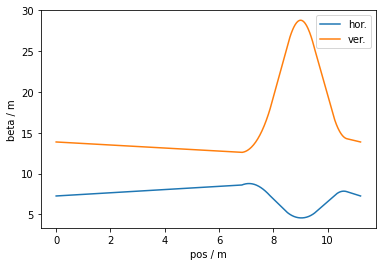

In [2]:
model = ThinLens.Models.SIS18_Cell_minimal_noDipoles(slices=10)  # 0-F-0-D-0-F-0

# visualize beta-function
twiss = model.getTwiss()

plt.plot(twiss["s"], twiss["betx"], label="hor.")
plt.plot(twiss["s"], twiss["bety"], label="ver.")
plt.legend()
plt.xlabel("pos / m")
plt.ylabel("beta / m")

track some particles

Text(0, 0.5, 'x / m')

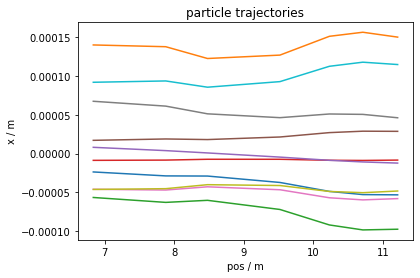

In [3]:
beam = ThinLens.Beam.Beam(mass=18.798, energy=19.0, exn=1.258e-5, eyn=2.005e-5, sigt=0.01, sige=0.005, particles=int(1e3))

trackedBunch = model(beam.bunch, outputPerElement=True)  # indices: particle, dim, element

# visualize
fig, ax = plt.subplots()
for particle in trackedBunch[:10].detach():
    ax.plot(model.endPositions, particle[0])

ax.set_title("particle trajectories")
ax.set_xlabel("pos / m")
ax.set_ylabel("x / m")

create a perturbed model and train it

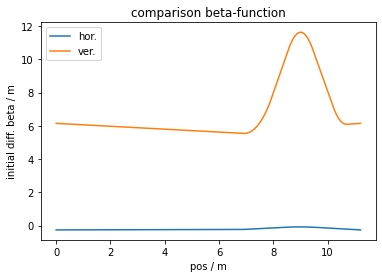

In [4]:
perturbedModel = ThinLens.Models.SIS18_Cell_minimal_noDipoles(k1f:=3.19391e-01, k1d=-4.7047e-01, slices=10)

# compare beta-function
perturbedTwiss = perturbedModel.getTwiss()
plt.plot(perturbedTwiss["s"], perturbedTwiss["betx"] - twiss["betx"], label="hor.")
plt.plot(perturbedTwiss["s"], perturbedTwiss["bety"] - twiss["bety"], label="ver.")

plt.legend()
plt.title("comparison beta-function")
plt.xlabel("pos / m")
plt.ylabel("initial diff. beta / m")

betaYLimBeforeTraining = plt.ylim()

In [5]:
# deactivate gradient computation for all weights
model.requires_grad_(False)
perturbedModel.requires_grad_(False)

# choose which parameters shall be trained
for element in perturbedModel.elements:
    if type(element) is ThinLens.Elements.Quadrupole:
        element.k1n.requires_grad_(True)  # quadrupole kick strength
        element.k2n.requires_grad_(False)  # sextupole kick strength

# prepare dataset for trainig
bunch = beam.bunch.detach().clone()
label = model(beam.bunch, outputPerElement=True)

trainSet = torch.utils.data.TensorDataset(bunch, label)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=25,
                                          shuffle=True, num_workers=2)

# set up optimizer
optimizer = torch.optim.Adam(perturbedModel.parameters(), lr=5e-2)
criterion = torch.nn.MSELoss()

In [6]:
epochs = 10

# train loop
t0 = time.time()

for epoch in range(epochs):
    for i, data in enumerate(trainLoader, 0):
        bunch, label = data[0], data[1]

        optimizer.zero_grad()

        out = perturbedModel(bunch, outputPerElement=True,)

#         loss = criterion(out, label)  # full phase-space
        loss = criterion(out[:, [0, 2], :], label[:, [0, 2], :])  # transversal coordinates only

        loss.backward()
        optimizer.step()

    print(loss.item())

print("training completed within {:.2f}s".format(time.time() - t0))

/home/conrad/miniconda3/envs/FODO/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


1.4532364027430855e-12
6.156471952243128e-14
2.6580242862414213e-14
1.1785405516892469e-14
9.106700243617476e-15
5.240276054340083e-15
3.0942755190657137e-15
2.0039414633167985e-15
1.259954521018957e-15
6.781167369403413e-16
training completed within 173.82s


check model performance after training

(-0.8550474643707275, 12.22820782661438)

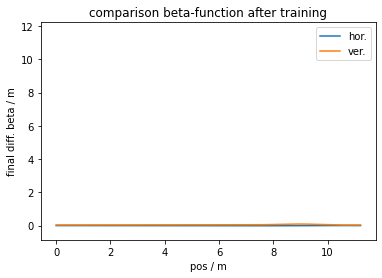

In [7]:
# compare beta-function
trainedTwiss = perturbedModel.getTwiss()
plt.plot(trainedTwiss["s"], trainedTwiss["betx"] - twiss["betx"], label="hor.")
plt.plot(trainedTwiss["s"], trainedTwiss["bety"] - twiss["bety"], label="ver.")

plt.title("comparison beta-function after training")
plt.legend()
plt.xlabel("pos / m")
plt.ylabel("final diff. beta / m")
plt.ylim(betaYLimBeforeTraining)